In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import LabelEncoder
import xgboost as xg
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error as MAE, r2_score

In [3]:
path = "/Users/afnan/Desktop/python/Data_science_Notes/Uber_data/4_ETA/preprocessed"

In [4]:
all_files = os.listdir("preprocessed/")
parquet_files = [file for file in all_files if file.endswith(".parquet")]

In [5]:
df1 = pd.read_parquet(f"{path}/{parquet_files[0]}")
df2 = pd.read_parquet(f"{path}/{parquet_files[1]}")
df3 = pd.read_parquet(f"{path}/{parquet_files[2]}")
df4 = pd.read_parquet(f"{path}/{parquet_files[3]}")
df5 = pd.read_parquet(f"{path}/{parquet_files[4]}")
df6 = pd.read_parquet(f"{path}/{parquet_files[5]}")
df7 = pd.read_parquet(f"{path}/{parquet_files[6]}")
df8 = pd.read_parquet(f"{path}/{parquet_files[7]}")

In [6]:
dfs = [df1, df2, df3, df4, df5, df6, df7, df8]

**Creating sample for model training**

In [7]:
combined_df = pd.DataFrame(columns=df1.columns)

In [8]:
for df in dfs:
    combined_df = pd.concat([combined_df, df.iloc[::50]])

In [9]:
combined_df.shape

(325547, 43)

In [9]:
combined_df.sample(3)

,pickup_date,hour_of_day,taxi_company,dispatching_base_num,PULocationID,DOLocationID,trip_miles,trip_time,shared_request_flag,shared_match_flag,...,snowdepth,avg_skyl,RA,SN,DZ,TS,FG,FZ,CLR,BR
143820,2021-06-16,10,Uber,B02865,169,75,7.350,24.350000,0,0,...,0,16500.000000,0,0,0,0,0,0,1,0
329260,2021-09-21,18,Uber,B02764,68,249,1.880,13.900000,0,0,...,0,3233.333333,0,0,0,0,0,0,1,0
1239250,2021-06-15,11,Lyft,B02510,37,37,0.895,6.416667,0,0,...,0,13566.666667,0,0,0,0,0,0,1,0


**Preparing training column**

In [10]:
low_corr = ['humidity', 'wind_speed', 'pressure', 'feel', 'avg_skyl', 'access_a_ride_flag', 'CLR', 'RA', 'TS', 
            'taxi_company', 'skyc1', 'skyc2', 'skyc3', 'snowdepth', 'precipitation', 'visibility']

In [11]:
train_cols = [col for col in list(combined_df.columns) if col not in low_corr]

In [12]:
train_cols.remove('pickup_date')
train_cols.remove('trip_time')   
train_cols.remove('minutes_per_mile') # target column  

In [13]:
object_col = list(combined_df.select_dtypes('object').columns)

In [14]:
obj_col = []
for column in object_col:
    try:
        combined_df[column] = combined_df[column].astype('float')
    except:
        obj_col.append(column)

In [15]:
obj_col

['pickup_date',
 'taxi_company',
 'dispatching_base_num',
 'day_of_week',
 'month',
 'PUBorough',
 'DOBorough',
 'PUservice_zone',
 'DOservice_zone',
 'Holiday',
 'wind_direction',
 'skyc1',
 'skyc2',
 'skyc3']

In [16]:
combined_df[obj_col] = combined_df[obj_col].apply(LabelEncoder().fit_transform)

## Mutual info

In [17]:
from sklearn.feature_selection import mutual_info_regression

In [18]:
mutual = mutual_info_regression(combined_df[train_cols], combined_df['minutes_per_mile'])

In [19]:
mutual_df = pd.DataFrame({'features': train_cols, 'mutual_info': mutual}).sort_values('mutual_info', ascending=False, ignore_index=True)
mutual_df.head(10)

,features,mutual_info
0,trip_miles,0.587827
1,DOLocationID,0.116821
2,PULocationID,0.084348
3,any_tolls,0.073273
4,hour_of_day,0.064869
5,DOservice_zone,0.051461
6,DOBorough,0.049957
7,traffic,0.049086
8,PUBorough,0.033377
9,PUservice_zone,0.026814


In [20]:
mutual_df.tail(10)

,features,mutual_info
14,wav_match_flag,0.001597
15,wind_direction,0.001453
16,shared_match_flag,0.000972
17,wav_request_flag,0.000621
18,DZ,0.000585
19,SN,0.000422
20,BR,0.000294
21,FG,0.000242
22,shared_request_flag,0.000035
23,FZ,0.000000


In [21]:
low_mutual = mutual_info_regression(combined_df[low_corr], combined_df['minutes_per_mile'])

In [22]:
low_mutual_df = pd.DataFrame({'features': low_corr, 'mutual_info': low_mutual}).sort_values('mutual_info', ascending=False, ignore_index=True)
low_mutual_df.head(5)

,features,mutual_info
0,access_a_ride_flag,0.032813
1,taxi_company,0.032794
2,humidity,0.009536
3,feel,0.006455
4,avg_skyl,0.003807


In [23]:
low_mutual_df.tail(5)

,features,mutual_info
11,CLR,0.0
12,RA,0.0
13,snowdepth,0.0
14,precipitation,0.0
15,visibility,0.0


## Variance reduction

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
train_X, test_X, train_y, test_y = train_test_split(combined_df[train_cols+ low_corr], combined_df['minutes_per_mile'], 
                      test_size = 0.2)
    
model = RandomForestRegressor()
model.fit(train_X, train_y)

RandomForestRegressor()

In [26]:
feature_importance = pd.DataFrame({'features': train_cols+low_corr, 'importance': model.feature_importances_})\
        .sort_values('importance', ascending=False, ignore_index=True)

In [27]:
feature_importance.head(10)

,features,importance
0,trip_miles,0.491387
1,traffic,0.068458
2,hour_of_day,0.051230
3,DOLocationID,0.045768
4,PULocationID,0.044196
5,feel,0.030458
6,humidity,0.029439
7,pressure,0.028281
8,avg_skyl,0.026383
9,DOBorough,0.025185


In [28]:
feature_importance.tail(10)

,features,importance
30,BR,0.000662
31,wav_request_flag,0.000580
32,snowdepth,0.000565
33,SN,0.000544
34,TS,0.000279
35,DZ,0.000236
36,FG,0.000199
37,shared_request_flag,0.000101
38,shared_match_flag,0.000072
39,FZ,0.000066


## Recursive feature elimination (RFE)

In [29]:
from sklearn.feature_selection import RFE

In [30]:
len(train_cols)

24

In [31]:
RFE_score = {}

In [32]:
# sample = combined_df.sample(frac=0.1)
train_X, test_X, train_y, test_y = train_test_split(combined_df[train_cols+low_corr], combined_df['minutes_per_mile'],test_size = 0.2)

In [33]:
for k in range(5, 41, 5):
    print(k)
    model = xg.XGBRegressor(n_estimators=30)
    selector = RFE(estimator=model, n_features_to_select=k, step=1)
    selector = selector.fit(train_X, train_y)
    
    sel_X_train = selector.transform(train_X)
    sel_X_test = selector.transform(test_X)
    
    model.fit(sel_X_train, train_y)
    RFE_preds = model.predict(sel_X_test)
    
    RFE_score[k] = MAE(test_y, RFE_preds)

5
10
15
20
25
30
35
40


In [34]:
n_features_df = pd.DataFrame({'n_feature': RFE_score.keys(), 'MAE': RFE_score.values()}).sort_values('MAE', ignore_index=True)

In [35]:
n_features_df

,n_feature,MAE
0,15,0.956973
1,20,0.961031
2,30,0.962892
3,35,0.963252
4,40,0.963252
5,25,0.963252
6,10,0.968204
7,5,1.024833


<Axes: xlabel='n_feature'>

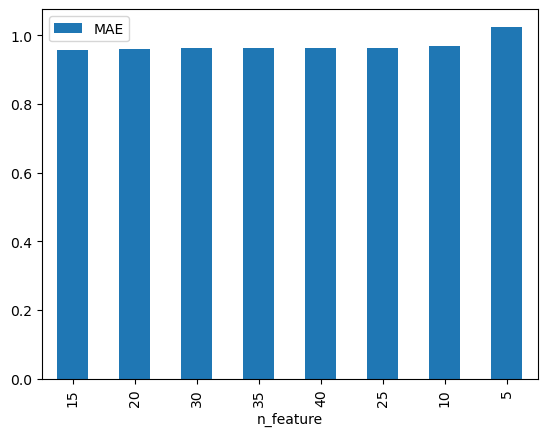

In [36]:
n_features_df.plot(kind='bar',x="n_feature", y="MAE")

In [37]:
for k in range(16, 20):
    print(k)
    model = xg.XGBRegressor(n_estimators=30)
    selector = RFE(estimator=model, n_features_to_select=k, step=1)
    selector = selector.fit(train_X, train_y)
    
    sel_X_train = selector.transform(train_X)
    sel_X_test = selector.transform(test_X)
    
    model.fit(sel_X_train, train_y)
    RFE_preds = model.predict(sel_X_test)
    
    RFE_score[k] = MAE(test_y, RFE_preds)

26
27
28
29


In [38]:
n_features_df = pd.DataFrame({'n_feature': RFE_score.keys(), 'MAE': RFE_score.values()}).sort_values('MAE', ignore_index=True)
n_features_df

,n_feature,MAE
0,15,0.956973
1,20,0.961031
2,28,0.961835
3,30,0.962892
4,26,0.963224
5,35,0.963252
6,40,0.963252
7,25,0.963252
8,29,0.963344
9,27,0.963668


comparing mutual info and RFE selectors features

In [39]:
RFE_selector = RFE(estimator=model, n_features_to_select=25, step=1)
RFE_selector.fit(train_X, train_y)

selected_features_mask = RFE_selector.get_support()

rfe_features = train_X.columns[selected_features_mask]
rfe_features

Index(['hour_of_day', 'dispatching_base_num', 'PULocationID', 'DOLocationID',
       'trip_miles', 'wav_request_flag', 'wav_match_flag', 'any_tolls',
       'day_of_week', 'month', 'traffic', 'PUBorough', 'DOBorough',
       'PUservice_zone', 'DOservice_zone', 'Holiday', 'SN', 'BR', 'humidity',
       'pressure', 'feel', 'avg_skyl', 'access_a_ride_flag', 'taxi_company',
       'skyc3'],
      dtype='object')

In [40]:
# set(mutual_df.head(15)['features']) ^ set(selected_features)

## SelectK features

In [41]:
from sklearn.feature_selection import SelectKBest

In [42]:
train_X, test_X, train_y, test_y = train_test_split(combined_df[train_cols+low_corr], combined_df['minutes_per_mile'],test_size = 0.2)

In [43]:
select_k_score = {}

In [44]:
for k in range(5, 41, 5):
    print(k)
    selector = SelectKBest(score_func=mutual_info_regression, k=k)
    X_train_selected = selector.fit_transform(train_X, train_y)
    
    model = xg.XGBRegressor(n_estimators=30)
    model.fit(X_train_selected, train_y)
    
    X_test_selected = selector.transform(test_X)
    
    y_pred = model.predict(X_test_selected)
    select_k_score[k] = MAE(test_y, y_pred)

5
10
15
20
25
30
35
40


In [45]:
k_features_df = pd.DataFrame({'k_feature': select_k_score.keys(), 'MAE': select_k_score.values()}).sort_values('MAE', ignore_index=True)

In [46]:
k_features_df

,k_feature,MAE
0,20,0.968394
1,30,0.969588
2,25,0.970146
3,40,0.970213
4,35,0.970733
5,15,0.974209
6,10,0.987006
7,5,1.029305


In [47]:
for k in range(26, 30):
    print(k)
    selector = SelectKBest(score_func=mutual_info_regression, k=k)
    X_train_selected = selector.fit_transform(train_X, train_y)
    
    model = xg.XGBRegressor(n_estimators=30)
    model.fit(X_train_selected, train_y)
    
    X_test_selected = selector.transform(test_X)
    
    y_pred = model.predict(X_test_selected)
    select_k_score[k] = MAE(test_y, y_pred)

26
27
28
29


In [48]:
k_features_df = pd.DataFrame({'k_feature': select_k_score.keys(), 'MAE': select_k_score.values()}).sort_values('MAE', ignore_index=True)
k_features_df

,k_feature,MAE
0,20,0.968394
1,27,0.968610
2,26,0.969333
3,30,0.969588
4,25,0.970146
5,40,0.970213
6,35,0.970733
7,28,0.972008
8,29,0.972143
9,15,0.974209


In [49]:
selector = SelectKBest(score_func=mutual_info_regression, k=25)
X_train_selected = selector.fit_transform(train_X, train_y)
k_best_features = selector.get_feature_names_out()

In [50]:
k_best_features

array(['hour_of_day', 'dispatching_base_num', 'PULocationID',
       'DOLocationID', 'trip_miles', 'wav_match_flag', 'any_tolls',
       'day_of_week', 'month', 'traffic', 'PUBorough', 'DOBorough',
       'PUservice_zone', 'DOservice_zone', 'Holiday', 'wind_direction',
       'humidity', 'wind_speed', 'feel', 'avg_skyl', 'access_a_ride_flag',
       'CLR', 'taxi_company', 'skyc2', 'skyc3'], dtype=object)

In [51]:
len(set(k_best_features)&set(rfe_features))

21

In [52]:
set(k_best_features)^set(rfe_features)

{'BR',
 'CLR',
 'SN',
 'pressure',
 'skyc2',
 'wav_request_flag',
 'wind_direction',
 'wind_speed'}

In [53]:
set(k_best_features)&set(rfe_features)&set(feature_importance.head(25)['features'])

{'DOBorough',
 'DOLocationID',
 'DOservice_zone',
 'PUBorough',
 'PULocationID',
 'PUservice_zone',
 'access_a_ride_flag',
 'any_tolls',
 'avg_skyl',
 'day_of_week',
 'dispatching_base_num',
 'feel',
 'hour_of_day',
 'humidity',
 'month',
 'skyc3',
 'taxi_company',
 'traffic',
 'trip_miles',
 'wav_match_flag'}